In [1]:
import torch
from torch.distributions import Normal

from Bs import Bs
from ParticleCloud import ParticleCloud
import matplotlib.pyplot as plt

In [2]:
from torch.distributions import Distribution

class IndependentPrior:
    def __init__(self, dists: list[Distribution]):
        self.dists = dists
        self.dim = len(dists)

    def sample(self, n_samples: int = 1) -> torch.Tensor:
        samples = [dist.sample((n_samples,)) for dist in self.dists]
        return torch.stack(samples, dim=-1).squeeze()

    def log_prob(self, x: torch.Tensor) -> torch.Tensor:
        log_probs = []
        for i, d in enumerate(self.dists):
            mask = d.support.check(x[:, i])         # Check if x is in the support
            lp = torch.full_like(x[:, i], -10**6)   # If not: set the log_prob to low value
            lp[mask] = d.log_prob(x[:, i][mask])

            log_probs.append(lp)
        return torch.stack(log_probs, dim=-1).sum(dim=-1)

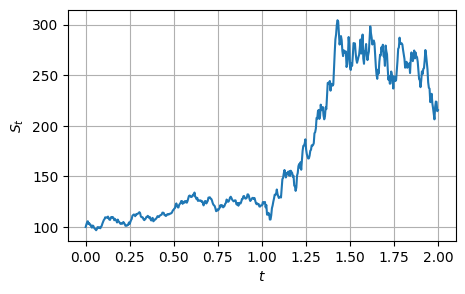

In [3]:
torch.manual_seed(42)

dt = torch.tensor(1 / 252)
model = Bs(dt=dt)
T = 1.0

S0 = torch.tensor(100.0)
params = torch.tensor([[0.1, 0.2]])
S1 = model.simulate(params, S0, T, M=1)
t1 = len(S1)

params = torch.tensor([[0.1, 0.5]])
S2 = model.simulate(params, S1[-1], T, M=1)

S = torch.concatenate([S1[:, 0], S2[:, 0]])

plt.figure(figsize=(5,3))
plt.plot(torch.linspace(0, 2 * T, len(S)), S.detach())
plt.xlabel(r'$t$')
plt.ylabel(r'$S_t$')
plt.grid()
plt.show()

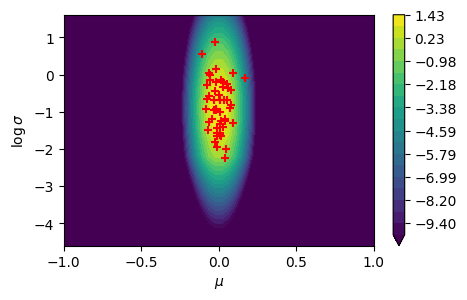

In [4]:
torch.manual_seed(0)
#pi_0 = Prior(dists = [Uniform(-1.0, 1.0), Uniform(1e-4, 1.0)])
pi_0 = IndependentPrior(dists=[
    Normal(loc=torch.tensor(0.0), scale=torch.tensor(0.05)),
    Normal(loc=torch.log(torch.tensor(0.4)), scale=torch.tensor(0.7))
])
n_particles = 50

pc = ParticleCloud(model, pi_0, n_particles, tau = 0.1)
fig = pc.plot(background='prior')

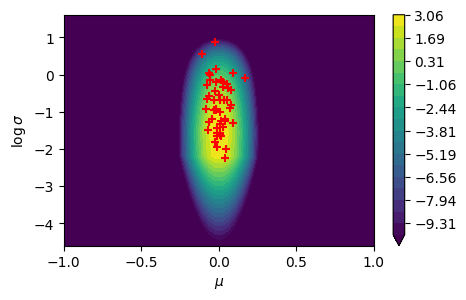

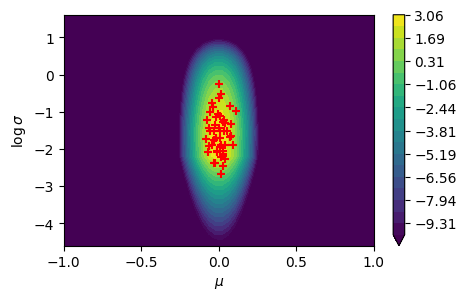

In [5]:
data1 = S[:t1]
fig = pc.plot(background='posterior', new_data=data1)

pc.update_svgd(data1, n_steps = 1000, lr = 0.01, h = -1)
fig = pc.plot(background='posterior', new_data=data1)

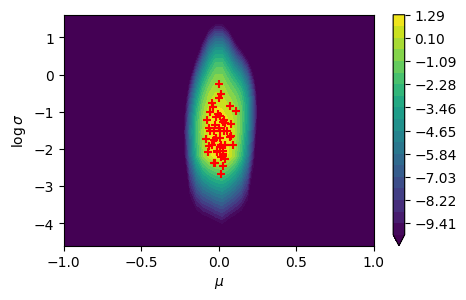

In [6]:
pc.update_prior()
fig = pc.plot(background='prior')